In [1]:
import numpy as np
import pandas as pd
import os
from pprint import pprint
import matplotlib.pyplot as plt
import lightgbm as lgb
import re
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings
warnings.simplefilter('ignore', UserWarning)
import eli5
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K
import xai
import time


Using TensorFlow backend.


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# reduce memory
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
train_df = reduce_mem(pd.read_csv('train.csv'))
train_df = train_df.sample(int(len(train_df)*0.3))
# fillna with median

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
normalized_x, y = train_df[feats], train_df['TARGET']
for col in tqdm(normalized_x, total=len(normalized_x.columns)):
    normalized_x[col] = normalized_x[col].replace([np.inf, -np.inf], np.nan) 
    np_array = normalized_x[col].to_numpy()
    normalized_x[col] = normalized_x[col].fillna(np.median(np_array[~np.isnan(np_array)]))
scaler = MinMaxScaler()
scaler.fit(normalized_x)
x = scaler.transform(normalized_x)
normalized_x = pd.DataFrame(x, columns = normalized_x.columns)
del train_df

-- Mem. usage decreased to 521.42 Mb (72.1% reduction),time spend:1.24 min


  0%|          | 0/795 [00:00<?, ?it/s]<ipython-input-5-44968b9d9425>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_x[col] = normalized_x[col].replace([np.inf, -np.inf], np.nan)
<ipython-input-5-44968b9d9425>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_x[col] = normalized_x[col].fillna(np.median(np_array[~np.isnan(np_array)]))
100%|██████████| 795/795 [00:01<00:00, 504.55it/s]


In [4]:
test_df = reduce_mem(pd.read_csv('test.csv'))
# fillna with median
normalized_test_x = test_df[feats]
for col in tqdm(normalized_test_x, total=len(normalized_test_x.columns)):
    normalized_test_x[col] = normalized_test_x[col].replace([np.inf, -np.inf], np.nan) 
    np_array = normalized_test_x[col].to_numpy()
    normalized_test_x[col] = normalized_test_x[col].fillna(np.median(np_array[~np.isnan(np_array)]))
scaler = MinMaxScaler()
scaler.fit(normalized_test_x)
x = scaler.transform(normalized_test_x)
normalized_test_x = pd.DataFrame(x, columns = normalized_test_x.columns)
del test_df

  0%|          | 0/795 [00:00<?, ?it/s]<ipython-input-4-b2d70c66a6cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_test_x[col] = normalized_test_x[col].replace([np.inf, -np.inf], np.nan)
<ipython-input-4-b2d70c66a6cb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_test_x[col] = normalized_test_x[col].fillna(np.median(np_array[~np.isnan(np_array)]))
100%|██████████| 795/795 [00:00<00:00, 1174.49it/s]


### XAI + NN

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
AUC = tf.keras.metrics.AUC(from_logits=False, name='auc')

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/model.h5',
    monitor='val_auc',
    mode='max',
    verbose=1,
    save_best_only=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=AUC)
history = model.fit(normalized_x.to_numpy(), y.to_numpy(), epochs=15, 
                    callbacks=[early_stop_callback, model_checkpoint_callback], validation_split=0.1, shuffle=True,
                    use_multiprocessing=True, workers=2)
model= tf.keras.models.load_model('./checkpoint/model.h5')

Epoch 1/15
8649/8649 [==============================] - 17s 2ms/step - loss: 0.2564 - auc: 0.7202 - val_loss: 0.2470 - val_auc: 0.7639

Epoch 00001: val_auc improved from -inf to 0.76392, saving model to ./checkpoint/model.h5
Epoch 2/15
8649/8649 [==============================] - 17s 2ms/step - loss: 0.2495 - auc: 0.7475 - val_loss: 0.2466 - val_auc: 0.7660

Epoch 00002: val_auc improved from 0.76392 to 0.76601, saving model to ./checkpoint/model.h5
Epoch 3/15
8649/8649 [==============================] - 17s 2ms/step - loss: 0.2477 - auc: 0.7530 - val_loss: 0.2462 - val_auc: 0.7683

Epoch 00003: val_auc improved from 0.76601 to 0.76831, saving model to ./checkpoint/model.h5
Epoch 4/15
8649/8649 [==============================] - 17s 2ms/step - loss: 0.2466 - auc: 0.7567 - val_loss: 0.2460 - val_auc: 0.7695

Epoch 00004: val_auc improved from 0.76831 to 0.76952, saving model to ./checkpoint/model.h5
Epoch 5/15
8649/8649 [==============================] - 17s 2ms/step - loss: 0.2454 - a

In [6]:
valid_auc = []
train_auc = []
folds = KFold(n_splits= 10, shuffle=True)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(normalized_x[feats], y)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    AUC = tf.keras.metrics.AUC(from_logits=False, name='auc')
    train_x, train_y = normalized_x[feats].iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = normalized_x[feats].iloc[valid_idx], y.iloc[valid_idx]

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./checkpoint/model_'+str(n_fold)+'.h5',
        monitor='val_auc',
        mode='max',
        verbose=1,
        save_best_only=True)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=AUC)
    history = model.fit(train_x.to_numpy(), train_y.to_numpy(), epochs=15, 
                        callbacks=[early_stop_callback, model_checkpoint_callback], validation_split=0.1, shuffle=True,
                        use_multiprocessing=True, workers=2)
    model= tf.keras.models.load_model('./checkpoint/model_'+str(n_fold)+'.h5')
    train_pred = model.predict(train_x.to_numpy())
    valid_pred = model.predict(valid_x.to_numpy())
    print(n_fold)
    print('Train AUC:', roc_auc_score(train_y, train_pred))
    train_auc.append(roc_auc_score(train_y, train_pred))
    print('Valid AUC:', roc_auc_score(valid_y, valid_pred))
    valid_auc.append(roc_auc_score(valid_y, valid_pred))

Epoch 1/15
7784/7784 [==============================] - 16s 2ms/step - loss: 0.2590 - auc: 0.7145 - val_loss: 0.2410 - val_auc: 0.7570

Epoch 00001: val_auc improved from -inf to 0.75698, saving model to ./checkpoint/model_0.h5
Epoch 2/15
7784/7784 [==============================] - 15s 2ms/step - loss: 0.2506 - auc: 0.7469 - val_loss: 0.2423 - val_auc: 0.7571

Epoch 00002: val_auc improved from 0.75698 to 0.75713, saving model to ./checkpoint/model_0.h5
Epoch 3/15
7784/7784 [==============================] - 15s 2ms/step - loss: 0.2487 - auc: 0.7524 - val_loss: 0.2394 - val_auc: 0.7591

Epoch 00003: val_auc improved from 0.75713 to 0.75911, saving model to ./checkpoint/model_0.h5
Epoch 4/15
7784/7784 [==============================] - 15s 2ms/step - loss: 0.2474 - auc: 0.7571 - val_loss: 0.2418 - val_auc: 0.7593

Epoch 00004: val_auc improved from 0.75911 to 0.75926, saving model to ./checkpoint/model_0.h5
Epoch 5/15
7784/7784 [==============================] - 15s 2ms/step - loss: 0.

In [6]:
model= tf.keras.models.load_model('./checkpoint/model.h5')

In [68]:
test_pred = model.predict(normalized_test_x.to_numpy())

In [69]:
submission = pd.read_csv('./input/sample_submission.csv')
submission['TARGET'] = test_pred
submission.to_csv('sample_submission.csv', index=False)

In [7]:
def feature_importance(x, y, func, repeat=10, plot=True):
    base_score = func(x, y)
    imp = [0] * len(x.columns)
    for i in range(repeat):
        for j, c in enumerate(x.columns):
            print(i, j)
            tmp = x[c].values.copy()
            np.random.shuffle(x[c].values)
            score = func(x, y)
            x[c] = tmp
            imp[j] += base_score - score
            del tmp
    imp = [a/repeat for a in imp]
    imp_df = pd.DataFrame(data=[imp], columns=x.columns)
    if plot:
        imp_df.sum().sort_values().plot.barh()
    return imp_df

def get_avg(x, y):
    return model.evaluate(x, y, verbose=10, batch_size=32)[1]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0.00653,0.001716,0.000447,-0.000005,0.000013,0.000025,0.00129,0.001063,0.000212,0.001315,...,0.000145,0.000008,0.000032,-0.000017,0.0,0.0,0.0,0.0,0.0,-0.000041


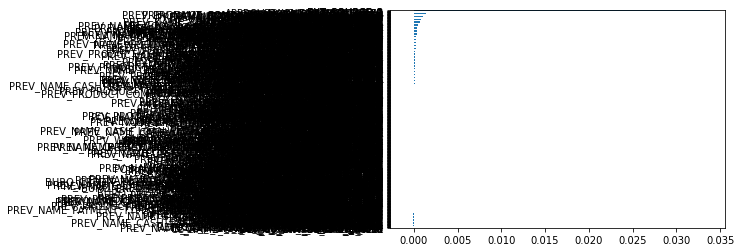

In [8]:
imp = feature_importance(normalized_x, y, get_avg, repeat=1)

imp.head()

In [10]:
temp_imp = pd.DataFrame()
temp_imp['feature'] = imp.columns
temp_imp['importance'] = imp.to_numpy().reshape(-1,1)

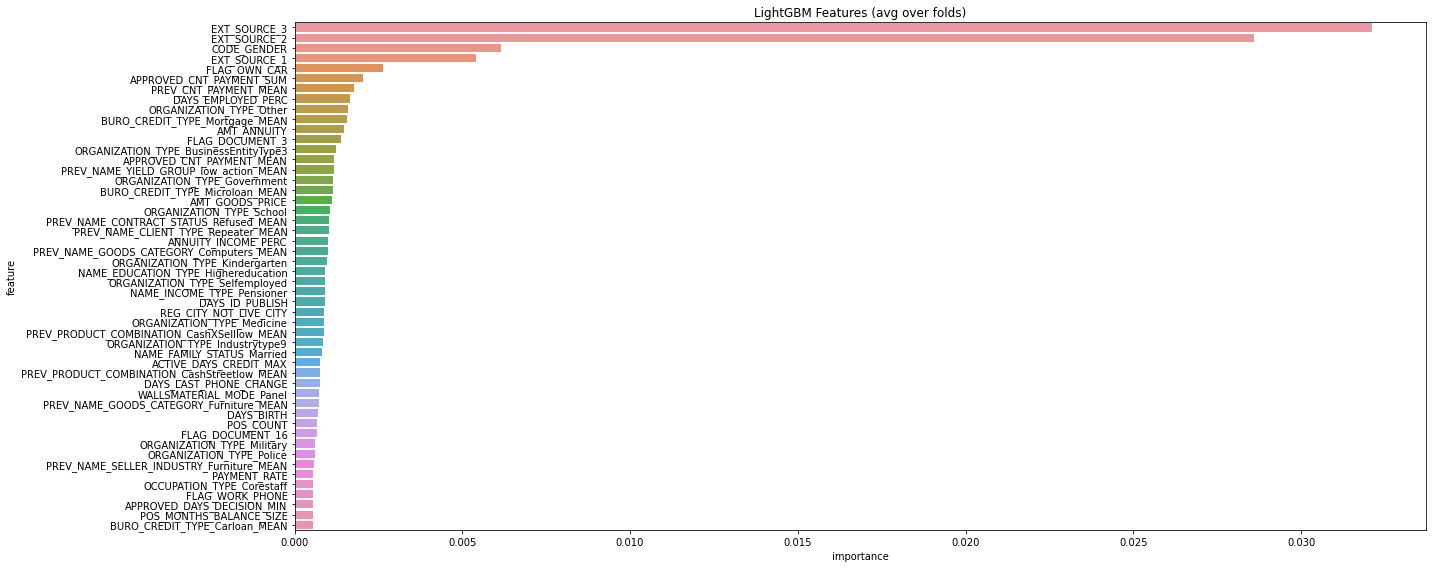

In [10]:
plt.figure(figsize=(20, 8))
sns.barplot(x="importance", y="feature", data=temp_imp.sort_values(by="importance", ascending=False).iloc[:50,:])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [11]:
temp_imp.to_csv('NN_importance2.csv',index=False)

In [13]:
import pandas as pandas

In [19]:
NN = pd.read_csv('NN_importance.csv')[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50]

In [20]:
NN

,importance
feature,
EXT_SOURCE_3,0.032108
EXT_SOURCE_2,0.028611
CODE_GENDER,0.006164
EXT_SOURCE_1,0.005419
FLAG_OWN_CAR,0.002643
APPROVED_CNT_PAYMENT_SUM,0.002028
PREV_CNT_PAYMENT_MEAN,0.001775
DAYS_EMPLOYED_PERC,0.001659
ORGANIZATION_TYPE_Other,0.001606
